<a href="https://colab.research.google.com/github/DongyounKim/ChartQA/blob/main/MaskImg_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmultimodal-nightly
!pip install datasets
!pip install transformers
#For tokenizer
!pip install sentencepiece

In [2]:
"""
Download dataset
"""
from datasets import load_dataset
#dataset = load_dataset("Dodon/ChartQA_dataset", split='train', streaming=True)
dataset = load_dataset("Dodon/ChartQA_dataset")
#dataset features names (key)
print(dataset['test'].features)

"""
Consideration
1. table and img_ann type ~ as Dict
2. 'query_tokens' ~ required
"""

{'imgname': Value(dtype='string', id=None), 'image': Image(decode=True, id=None), 'human': Value(dtype='bool', id=None), 'query': Value(dtype='string', id=None), 'query_token': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'label': Value(dtype='string', id=None), 'table_name': Value(dtype='string', id=None), 'table': Value(dtype='string', id=None), 'img_ann': Value(dtype='string', id=None)}


"\nConsideration\n1. table and img_ann type ~ as Dict\n2. 'query_tokens' ~ required\n"

In [3]:
"""
Example dataset ~ range(10)
"""
example_data = dataset['train'].select(range(10))
#Display ()

In [4]:
"""
After load PlotQA ~ add dataset preprocessing class depends on their dataset
"""
# from torch.utils.data import Dataset
# class ChartQAdataset(Dataset):
#   #NUM_LABELS = 5
#   def __init__(self, data_args, tokenizer, mode ='train'):
#     self.tokenizer = tokenizer
#     self.num_img_embeds = 0

'\nAfter load PlotQA ~ add dataset preprocessing class depends on their dataset\n'

2. Load pre-trained tokenizer
  
  a. Text - T5 small

  b. Image -

In [5]:
"""
Tokenizer
1. image to tensor
2. text to tensor
3. [masking area]
"""
import torch
from PIL import Image
import torchvision.transforms as transforms
from transformers import T5Tokenizer, T5TokenizerFast, PreTrainedTokenizer, PreTrainedTokenizerBase

tokenizer = T5Tokenizer.from_pretrained("t5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
"""
Text to tensor
"""
queries = example_data['query']
print(queries)
token_query = tokenizer(queries, padding=True, truncation=True, return_tensors="pt")
print(token_query['input_ids'])

['As of 2021, how many championship titles had Ferrari won?', 'What game topped the charts with 512.3 million hours watched on Twitch in the first half of 2019?', 'How many hours did League of Legends watch on Twitch in the first half of 2019?', 'Which country was the leading pharmaceutical supplier to Germany in 2019?', 'What is the region with the highest number of ICUs in Italy?', 'What was the global sales income of certified Fairtrade International coffee in 2018?', "What percentage of Belize's GDP did the national debt amount to in 2019?", 'In what year did the Mexican government spend 6.61 billion dollars in the military?', 'How much did the Mexican government spend in the military a year earlier?', 'What percentage of the GDP of the United States was exported in 1990?']
tensor([[  282,    13,   460,  2658,     6,   149,   186, 10183,  8342,   141,
         21945,   751,    58,     1,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  363,

In [7]:
"""
Image to tensor
"""

imgs = example_data['image']
print(imgs)
transform = transforms.Compose([
    transforms.PILToTensor()
    #Augmentation + crop
     ])
img_tensors = transform(imgs[0])
#torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
print(img_tensors.shape)

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x836 at 0x7B79CCD8CDF0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x557 at 0x7B79CCD8CDC0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x557 at 0x7B79CCD8CE20>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x716 at 0x7B79CC7095D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x1056 at 0x7B79CC709600>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x557 at 0x7B79CC709630>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x557 at 0x7B79CC709660>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x557 at 0x7B79CC709690>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x557 at 0x7B79CC7096C0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x1286 at 0x7B79CC7096F0>]
torch.Size([4, 836, 800])


In [32]:
import matplotlib.pyplot as plt
import ast
import random
import torchvision.transforms.functional as F

def convert_dict(_img_ann):
    batch = {}
    # Your data collation logic here
    #for _idx, sample in enumerate(samples):
    if type(_img_ann) == str:
      if (len(_img_ann)>0):
        img_annotation = ast.literal_eval(_img_ann)
    else:
      img_annotation= _img_ann
      #print("index : ", _idx )
      print("Error")
      print(_img_ann)
    #collated_data = {'img_a':img_annotation}
    #return collated_data
    return img_annotation
"""
mask_config format
"""
#!requirement: change the mask_config format
mask_config = {'msk_region': 'random', 'msk_ratio': 0.2}
class Masking_img:
  def __init__(self, mask_config, transform = transforms.Compose([transforms.PILToTensor()])):
    self.mask_region = mask_config['msk_region']
    self.mask_ratio = mask_config['msk_ratio']
    self.transforms = transform

  def __call__(self, data):
    self.img_name = data['imgname']

    print(self.img_name)

    self.original_img = data['image'].convert('RGB')
    self.img_tensor = self.transforms(self.original_img)
    self.img_label = self.img_tensor.clone()
    #
    self.height, self.width = self.img_label.shape[1], self.img_label.shape[2]
    print(f"Image size: {self.height, self.width}")

    #self.total_mask_img = torch.randint(1,(self.height, self.width))
    #print(self.total_mask_img)
    """
    1. Load Image annotation (Type change)
    """
    #img_annotation
    self.img_ann = convert_dict(data['img_ann'])
    #print(self.img_ann) # dict
    #tensor

    """
    2.a Masking random
    """
    if self.mask_region == 'random':
      print("Random range")
      return self.img_label, self.random_masking()

    elif self.mask_region =='axis':
      print("Under Construction")
      return self.original_img, self.img_tensor
    """
    3. Resize them following the model
    """
    #return self.original_img, self.img_tensor

  """
  return the tensor
  """
  def random_masking(self):
    if ('figure_info' in self.img_ann['general_figure_info']):
      self._candidate_bbox = [self.img_ann['general_figure_info']['figure_info']['bbox']]
      self._name = "Random in figure info"
      """
      Mask a region
      """
      #1. Grid information
      self._x, self._y = self._candidate_bbox[0]['x'], self._candidate_bbox[0]['y']
      self._w, self._h = self._candidate_bbox[0]['w'], self._candidate_bbox[0]['h']
      """
      Grid size = each erased grid size relied on mask ratio
      self._area = self._h * self._w
      """
      self._grid_w = int(self._w * self.mask_ratio * 0.8)
      self._grid_h = int(self._h * self.mask_ratio* 0.8)
      # The number of grid
      self.num_grid = 50
      self._grid_list = []
      random.seed(5)
      for _tmp in range(self.num_grid):
        self._g_x = random.randint(self._x, self._x+self._w)
        self._g_y = random.randint(self._y, self._y+self._h)
        self._grid_list.append((self._g_x,self._g_y))

      self._masked_image = self.img_tensor.clone()
      for _loc in self._grid_list:
        self._masked_image=F.erase(self._masked_image, _loc[1],_loc[0], self._grid_w, self._grid_h, torch.zeros(1))

      """
      Visualization
      """
      #self.masked_output_img = F.to_pil_image(self._masked_image)
      #plt.imshow(self.masked_output_img)
      #plt.show()
      #tensor return
      return self._masked_image
    else:
      print("total")
      #1. Grid information
      self._x, self._y = 0, 0
      self._w, self._h = self.height, self.width
      #Random masking
      """
      Same above after assigning the area
      Grid size = each erased grid size relied on mask ratio
      self._area = self._h * self._w
      """
      self._grid_w = int(self._w * self.mask_ratio * 0.8)
      self._grid_h = int(self._h * self.mask_ratio* 0.8)
      # The number of grid
      self.num_grid = 50
      self._grid_list = []
      random.seed(5)
      for _tmp in range(self.num_grid):
        self._g_x = random.randint(self._x, self._x+self._w)
        self._g_y = random.randint(self._y, self._y+self._h)
        self._grid_list.append((self._g_x,self._g_y))

      self._masked_image = self.img_tensor.clone()
      for _loc in self._grid_list:
        self._masked_image=F.erase(self._masked_image, _loc[1],_loc[0], self._grid_w, self._grid_h, torch.zeros(1))

      self.masked_output_img = F.to_pil_image(self._masked_image)
      plt.imshow(self.masked_output_img)
      plt.show()
      #tensor return
      return self._masked_image

two_col_103562.png
Image size: (836, 800)
Random range


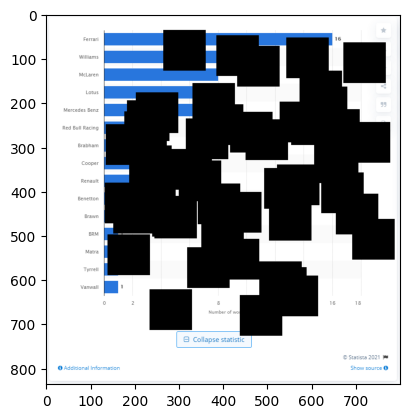

tensor([[[253, 253, 253,  ..., 252, 252, 252],
         [253, 253, 253,  ..., 252, 252, 251],
         [253, 253, 252,  ..., 251, 251, 251],
         ...,
         [251, 250, 249,  ..., 249, 250, 251],
         [251, 250, 250,  ..., 250, 250, 251],
         [251, 251, 250,  ..., 250, 251, 251]],

        [[253, 253, 253,  ..., 252, 252, 252],
         [253, 253, 254,  ..., 253, 252, 251],
         [253, 254, 253,  ..., 252, 252, 251],
         ...,
         [252, 251, 250,  ..., 250, 251, 252],
         [252, 251, 251,  ..., 251, 251, 252],
         [251, 252, 251,  ..., 251, 252, 251]],

        [[254, 254, 254,  ..., 253, 253, 254],
         [254, 254, 254,  ..., 253, 254, 253],
         [254, 254, 253,  ..., 253, 253, 253],
         ...,
         [253, 252, 251,  ..., 251, 252, 253],
         [252, 252, 252,  ..., 252, 252, 252],
         [252, 252, 252,  ..., 252, 252, 252]]], dtype=torch.uint8)
torch.Size([3, 836, 800])
tensor([[[253, 253, 253,  ..., 252, 252, 252],
         [253,

In [18]:
msk_generator = Masking_img(mask_config)
_org, _tensor = msk_generator(example_data[0])
print(_org)
print(_tensor.shape)
#repr(msk_generator)
print(_tensor.clone())

In [36]:
from typing import Dict, List, Optional, Union
class data_collator:
  mask_config = {'msk_region': 'random', 'msk_ratio': 0.2}
  max_length: Optional[int] = 1024
  max_length_decoder: Optional[int] = 512

  def __init__(self, text_tokenizer = tokenizer):
    self.text_token = tokenizer
    self.Mask_class = Masking_img(mask_config)

  def __call__(self, features):
    batch = {}
    batch_size = len(features)
    print(batch_size)

    mask_img_list = []
    label_img_list= []
    for _f in features:
      if 'image' in _f:
        label_img, masked_img = self.Mask_class(_f)
        mask_img_list = torch.stack([masked_img])
        label_img_list = torch.stack([label_img])
    if 'query' in features[0].keys():
      queries = features['query']
      token_query = self.text_token(queries, padding=True, truncation=True, return_tensors="pt")
      batch.update({'query': token_query['input_ids']})

    if 'label' in features[0].keys():
      queries = features['label']
      token_answers = self.text_token(queries, padding=True, truncation=True, return_tensors="pt")
      batch.update({'answer': token_answers['input_ids']})

    batch.update({'mask_img':mask_img_list})
    batch.update({'label_img':label_img_list})
    return batch

In [37]:
data_call = data_collator()
batch=data_call(example_data)

10
two_col_103562.png
Image size: (836, 800)
Random range
two_col_2954.png
Image size: (557, 800)
Random range
two_col_2954.png
Image size: (557, 800)
Random range
two_col_61737.png
Image size: (716, 800)
Random range
multi_col_40810.png
Image size: (1056, 800)
Random range
two_col_62773.png
Image size: (557, 800)
Random range
two_col_82868.png
Image size: (557, 800)
Random range
two_col_60067.png
Image size: (557, 800)
Random range
two_col_60067.png
Image size: (557, 800)
Random range
two_col_812.png
Image size: (1286, 800)
Random range


In [38]:
batch

{'query': tensor([[  282,    13,   460,  2658,     6,   149,   186, 10183,  8342,   141,
          21945,   751,    58,     1,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0],
         [  363,   467,     3, 12403,     8, 12321,    28, 11696, 18561,   770,
            716,  7533,    30, 12119,    17,   524,    16,     8,   166,   985,
             13,  1360,    58,     1],
         [  571,   186,   716,   410,  3815,    13, 13637,     7,  1605,    30,
          12119,    17,   524,    16,     8,   166,   985,    13,  1360,    58,
              1,     0,     0,     0],
         [ 4073,   684,    47,     8,  1374, 14106,  8106,    12,  3434,    16,
           1360,    58,     1,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0],
         [  363,    19,     8,  1719,    28,     8,  2030,   381,    13,    27,
           5211,     7,    16,  5308,    58,     1,     0,     0,     0,     0,
              0,     0,     0,     

In [40]:
!nvidia-smi

Thu Sep 28 03:40:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [41]:
# import torch
# import requests
# from PIL import Image
# from transformers import BlipProcessor, BlipForQuestionAnswering

# processor = BlipProcessor.from_pretrained("ybelkada/blip-vqa-base")
# model = BlipForQuestionAnswering.from_pretrained("ybelkada/blip-vqa-base", torch_dtype=torch.float16).to("cuda")

# img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# question = "how many dogs are in the picture?"
# inputs = processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

# out = model.generate(**inputs)
# print(processor.decode(out[0], skip_special_tokens=True))

In [43]:
"""
Deplot inference
"""
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration
import requests
from PIL import Image

processor = Pix2StructProcessor.from_pretrained('google/deplot')
model = Pix2StructForConditionalGeneration.from_pretrained('google/deplot')

url = "https://raw.githubusercontent.com/vis-nlp/ChartQA/main/ChartQA%20Dataset/val/png/5090.png"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, text="Generate underlying data table of the figure below:", return_tensors="pt")
predictions = model.generate(**inputs, max_new_tokens=512)
print(processor.decode(predictions[0], skip_special_tokens=True))

Entity | Individuals responsibility | Government's responsibility <0x0A> MEDIAN | 39.0 | 55.0 <0x0A> Germany | nan | 35.0 <0x0A> UK | 45.0 | 49.0 <0x0A> Sweden | 37.0 | 53.0 <0x0A> Denmark | 42.0 | 54.0 <0x0A> France | 38.0 | 55.0 <0x0A> Netherla nns | 40.0 | 58.0 <0x0A> Spain | 29.0 | 63.0 <0x0A> Italy | 22.0 | 74.0
